# Nowcast evaluation

In [1]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.realtime_utils import *
from src.load_data import *
from plotnine import *

In [2]:
model_names = {
    'KIT-MeanEnsemble' : 'Ensemble',
    'lightgbm_retrain': 'LightGBM',
    'lightgbm_precov': 'LightGBM-PreCov',
    'lightgbm_oracle': 'LightGBM-Oracle',
    'tsmixer_retrain' : 'TSMixer',
    'tsmixer_precov': 'TSMixer-PreCov',
    #'KIT-hhh4' : 'hhh4-noCov',
    'KIT-hhh4_all_data': 'hhh4',
    'KIT-baseline' : 'Nowcast',
    'KIT-persistence': 'Baseline-Persistence',
    'baseline' : 'Baseline-Historical'
}

In [3]:
model_colors = {
    "LightGBM": "#B30000",
    'LightGBM-Oracle': "#B30000",
    "TSMixer": "#E69F00",
    'TSMixer-Retrain': "#E69F00",
    'TSMixer-PreCov': "#E69F00",
    "LightGBM-Retrain": "#999999",
    "Nowcast": "#56B4E9",
    "hhh4_all_data": "#F0E442",
    "Ensemble": "#009E73",
    'LightGBM-PreCov': "#60D1B3",
    "Baseline-Historical": "#80471C",
    'Baseline-Persistence' : "#80471C",
    "hhh4": "#3C4AAD",
    "hhh4_all_data_skip": "#CC79A7",
    "LightGBM-Skip": "#000000"
}

In [4]:
def load_nowcasts(start='2023-11-16', end='2024-09-19', include_truth=True):
    files = glob.glob(f'../data/nowcasts/KIT-baseline/*.csv') 

    dfs = []
    for file in files:
        df_temp = pd.read_csv(file)
        df_temp['model'] = file[:-4].split('/')[-1].split('-', 5)[-1]
        dfs.append(df_temp)
    df = pd.concat(dfs)
    
    df = df[df.forecast_date.between(start, end)].reset_index(drop=True)
    
    if include_truth:
        df = add_truth(df, target=True)
    
    return df

In [5]:
df_nowcasts = load_nowcasts()

In [6]:
df = load_predictions('post-covid')

In [7]:
MODELS = ['lightgbm_retrain',#'lightgbm_precov',
          'lightgbm_oracle',
          'tsmixer_retrain', #'tsmixer_precov', 
          'baseline', 'KIT-persistence',
          'KIT-hhh4_all_data', #'KIT-hhh4',
          'KIT-MeanEnsemble']

In [8]:
# df = df[~df.model.isin(['lightgbm', 'lightgbm2'])]

In [9]:
df = df[df.model.isin(MODELS)]

In [10]:
df.model.unique()

array(['tsmixer_retrain', 'lightgbm_retrain', 'baseline',
       'KIT-persistence', 'lightgbm_oracle', 'KIT-hhh4_all_data',
       'KIT-MeanEnsemble'], dtype=object)

In [11]:
df = pd.concat([df, df_nowcasts], ignore_index=True)

In [12]:
df = df[df['quantile'].isin([0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975])]

In [13]:
df.model = df.model.replace(model_names)

In [14]:
df = df[df.forecast_date != '2023-12-28']

In [15]:
# df = df[df.target_end_date.between('2023-01-04', '2024-09-15')].reset_index(drop=True)

In [16]:
df = df[df.forecast_date.between('2023-11-16', '2024-09-15')].reset_index(drop=True)

In [17]:
df.forecast_date.min()

'2023-11-16'

In [18]:
df.forecast_date.max()

'2024-09-12'

# Compute scores

#### National level

In [19]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,107.971429,108.383721,43.585548,259.940698,0.436047,0.959302
1,Ensemble,439.565077,172.478837,356.460427,968.504342,0.523256,0.976744
2,TSMixer,488.082541,296.324327,285.316159,1069.723027,0.587209,0.959302
3,LightGBM,400.940764,52.842545,653.096853,1106.880162,0.552326,0.936047
4,hhh4,429.671927,390.166944,368.155316,1187.994186,0.447674,0.889535
5,LightGBM-Oracle,340.592709,62.802004,793.469239,1196.863952,0.360465,0.889535
6,Baseline-Persistence,672.385922,641.775748,298.365449,1612.527118,0.581395,0.912791
7,Baseline-Historical,458.267954,12.857143,1600.589768,2071.714865,0.189189,0.506757


In [20]:
# evaluate_models(df, 'national', by_horizon=True)

#### Age groups

In [20]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,16.697010,26.173865,17.120155,59.991030,0.371124,0.811047
1,Ensemble,95.666729,44.403161,62.374769,202.444659,0.533915,0.959302
2,LightGBM,69.571635,32.892676,124.591757,227.056068,0.347868,0.820736
3,LightGBM-Oracle,60.047060,31.586457,143.380493,235.014010,0.274225,0.782946
4,hhh4,118.145764,65.449612,54.678295,238.273671,0.579457,0.964147
5,TSMixer,99.282788,69.968401,77.721633,246.972823,0.466085,0.881783
6,Baseline-Persistence,104.014030,126.905177,73.104928,304.024135,0.440891,0.810078
7,Baseline-Historical,97.237524,7.680985,239.796654,344.715162,0.269144,0.625000


In [22]:
# evaluate_models(df, 'age', by_horizon=True)

In [23]:
# evaluate_models(df, 'age', by_age=True)

# Combined scores

In [22]:
def evaluate_models(df, level=None, by_horizon=False, by_age=False):
    if level is not None:
        df_temp = filter_by_level(df, level)
    else:
        df_temp = df
    if by_horizon:
        wis_temp = df_temp.groupby('horizon')[df_temp.columns].apply(compute_wis).reset_index().drop(columns='level_1')
        coverage_temp = df_temp.groupby('horizon')[df_temp.columns].apply(compute_coverage).reset_index().drop(columns='level_1')
        results = wis_temp.merge(coverage_temp, on=['model', 'horizon']).sort_values(['horizon', 'wis'], ignore_index=True)
    elif by_age:
        wis_temp = df_temp.groupby('age_group')[df_temp.columns].apply(compute_wis).reset_index().drop(columns='level_1')
        coverage_temp = df_temp.groupby('age_group')[df_temp.columns].apply(compute_coverage).reset_index().drop(columns='level_1')
        results = wis_temp.merge(coverage_temp, on=['model', 'age_group']).sort_values(['age_group', 'wis'], ignore_index=True)        
    else:
        wis_temp = compute_wis(df_temp)
        coverage_temp = compute_coverage(df_temp)
        results = wis_temp.merge(coverage_temp, on='model').sort_values('wis', ignore_index=True)
    
    return results

In [23]:
evaluate_models(df)

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,29.736213,37.918130,20.900925,88.555268,0.380399,0.832226
1,Ensemble,144.795065,62.699686,104.387006,311.881757,0.532392,0.961794
2,LightGBM,116.910082,35.742657,200.092485,352.745224,0.377076,0.837209
3,TSMixer,154.825610,102.304962,107.377994,364.508566,0.483389,0.892857
4,LightGBM-Oracle,100.125010,36.045821,236.250314,372.421145,0.286545,0.798173
5,hhh4,162.649502,111.837803,99.460726,373.948030,0.560631,0.953488
6,Baseline-Persistence,185.210014,200.458116,105.285002,490.953132,0.460963,0.824751
7,Baseline-Historical,148.813300,8.420436,434.195670,591.429406,0.257722,0.608108


# Plots

## By horizon

In [24]:
df_national = evaluate_models(df, 'national', by_horizon=True)
df_age = evaluate_models(df, 'age', by_horizon=True)

df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

df_long = pd.melt(df_wide, id_vars=['level', 'horizon', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

df_long['level'] = pd.Categorical(df_long['level'], categories=['national', 'age'], ordered=True)

In [25]:
def plot_scores_by_horizon_and_model(df, level='national'):
    scores = df[df.level==level].copy()
    
    desired_order = ['Nowcast', 'Ensemble', 'LightGBM', 'LightGBM-Oracle', 'TSMixer', 'hhh4', 'Baseline-Persistence', 'Baseline-Historical']
    scores['model'] = pd.Categorical(scores['model'], categories=desired_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=model_colors)
        + scale_fill_manual(values=model_colors)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="WIS by horizon")
        + facet_grid(cols='horizon', scales="free", space='free')  # Create a facet for each horizon
        #+ facet_wrap('~horizon', nrow=1, scales='free_x', space='free')  # Create a facet for each horizon
        + theme_bw()
        + theme(legend_position='bottom',
            legend_title_position='left',
            strip_text=element_text(size=9),             # Facet title text size
            legend_title=element_text(size=9),           # Legend title text size
            legend_text=element_text(size=8),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),               # Axis text (tick labels) size
            axis_text_y=element_text(size=9),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=11)            # Plot title text size)
       )
        #+ coord_flip()
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


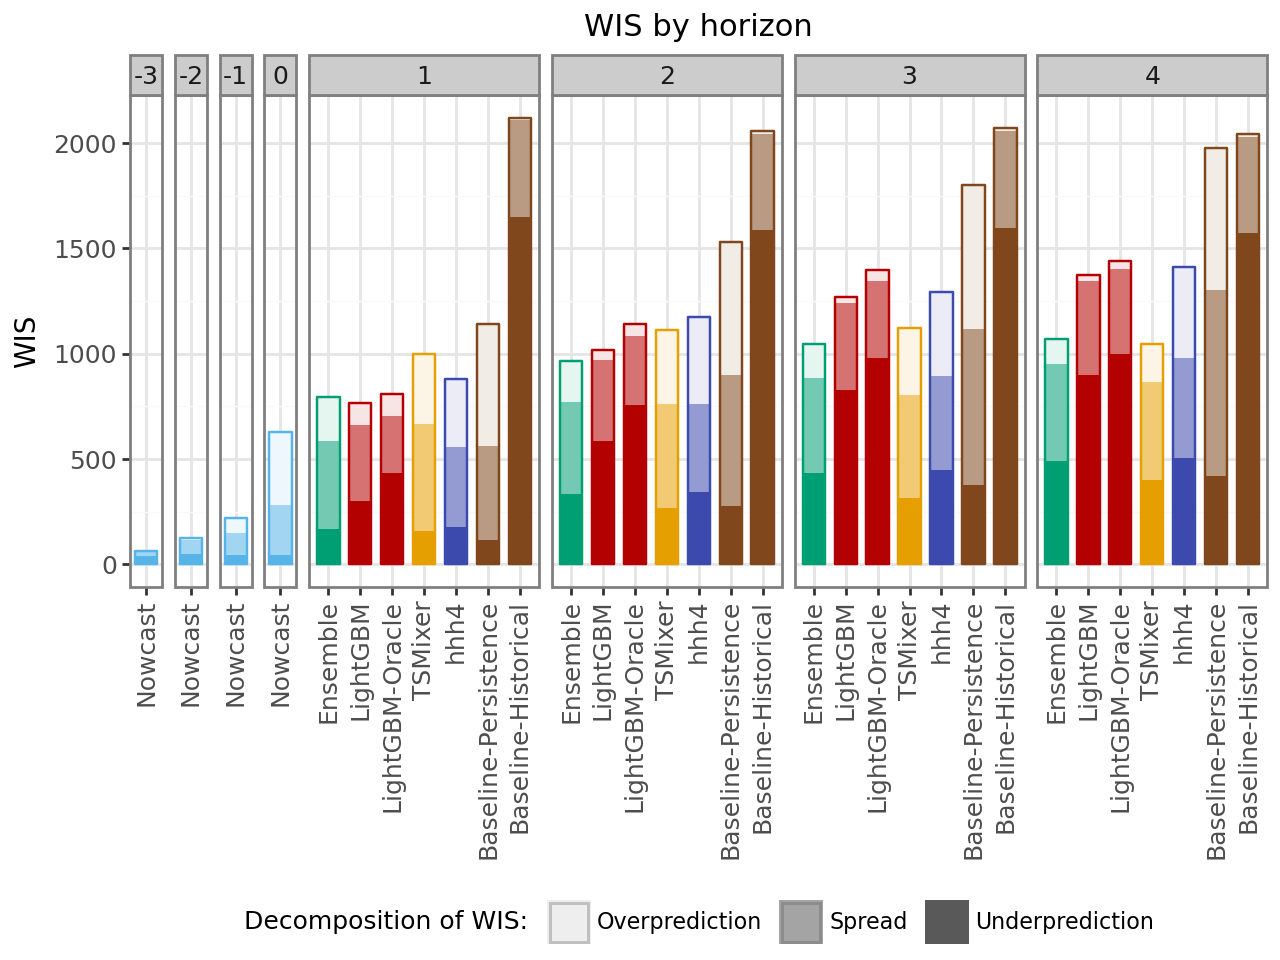

In [26]:
p = plot_scores_by_horizon_and_model(df_long, 'national')
p 

In [29]:
p.save("../figures/wis_national_horizon.pdf", width = 165, height = 120, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 165.0 x 120.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_national_horizon.pdf


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


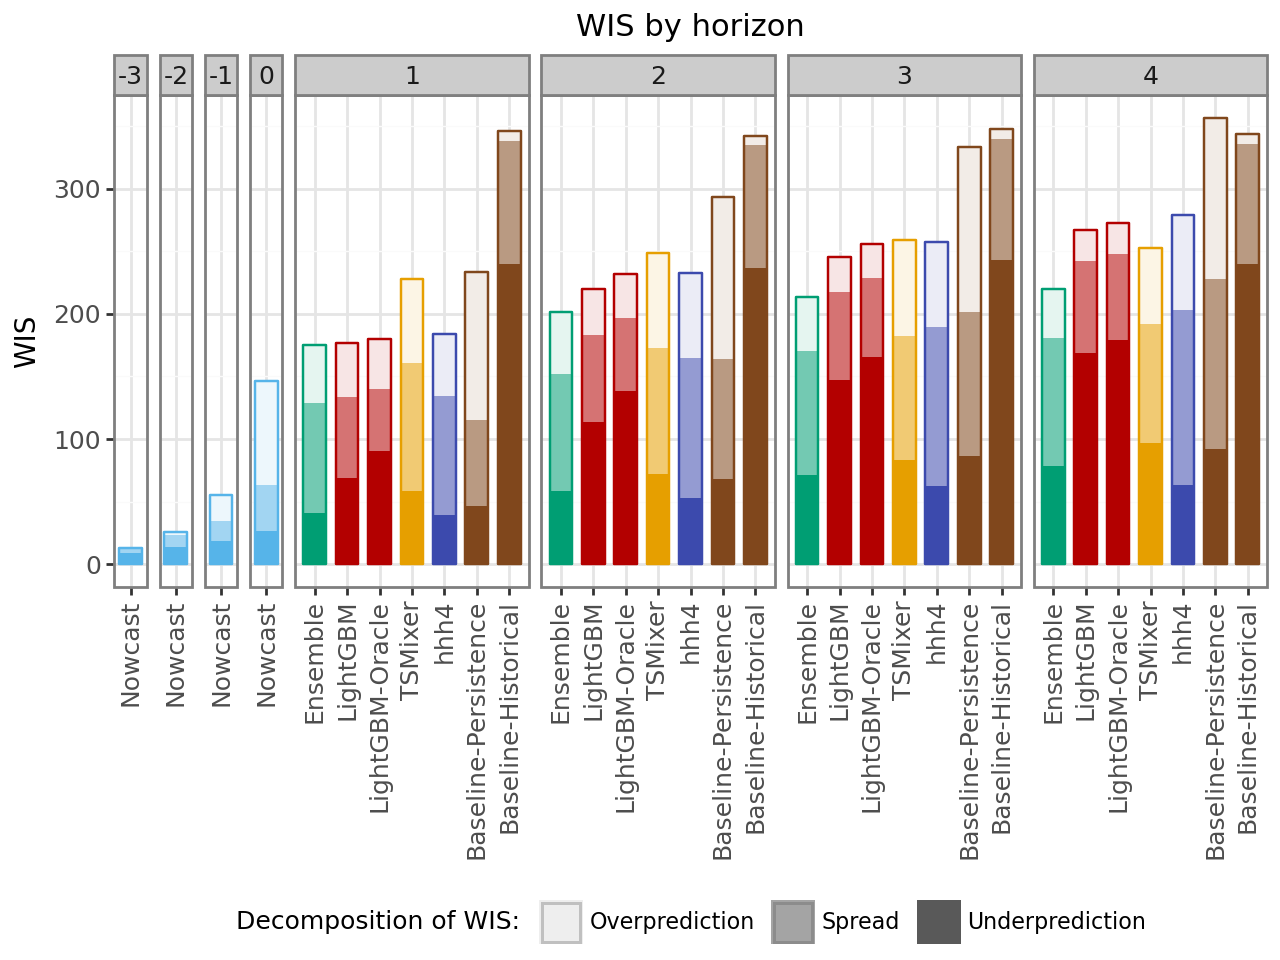

In [27]:
p = plot_scores_by_horizon_and_model(df_long, 'age')
p 

In [31]:
p.save("../figures/wis_age_horizon.pdf", width = 165, height = 120, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 165.0 x 120.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age_horizon.pdf


## By age group

In [32]:
df.model.unique()

array(['TSMixer', 'LightGBM', 'Baseline-Historical',
       'Baseline-Persistence', 'hhh4', 'Ensemble', 'Nowcast'],
      dtype=object)

In [33]:
scores_age = evaluate_models(df[df.model != 'Nowcast'], 'age', by_age=True)

In [34]:
scores_age = pd.melt(scores_age, id_vars=['age_group', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

In [35]:
def plot_scores_by_age_group(scores):
    desired_order = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4', 'Baseline-Persistence', 'Baseline-Historical']
    scores['model'] = pd.Categorical(scores['model'], categories=desired_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=model_colors)
        + scale_fill_manual(values=model_colors)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS:", title="")
        + facet_wrap('~age_group')
        + theme_bw()
        + theme(legend_position='right',
            legend_title_position='top',
            strip_text=element_text(size=10),             # Facet title text size
            legend_title=element_text(size=9),           # Legend title text size
            legend_text=element_text(size=8),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),               # Axis text (tick labels) size
            axis_text_y=element_text(size=9),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=14)              # Plot title text size)
       )
        #+ coord_flip()
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


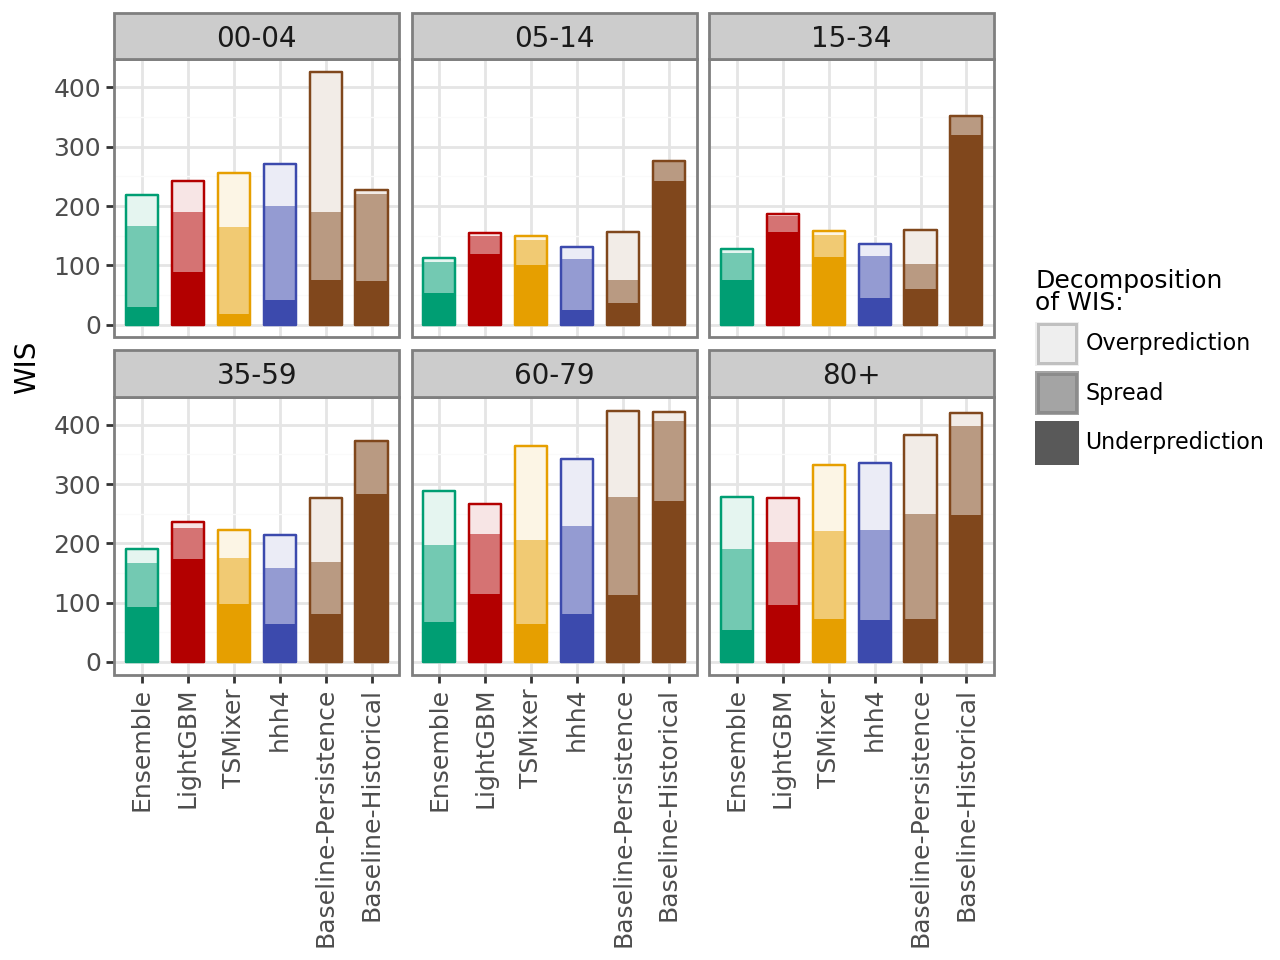

In [36]:
p = plot_scores_by_age_group(scores_age)
p

In [37]:
p.save("../figures/wis_age.pdf", width = 160, height = 110, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 110.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age.pdf
